In [9]:
import sys
sys.path.append("/home/ubuntu/roaddetection/")

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from keras.preprocessing import image
from src.models.data import *
from src.models.metrics_img import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.utils import np_utils

import pandas as pd
from sklearn.utils import shuffle

from PIL import Image

import rasterio as rio

%matplotlib inline

In [11]:
import os, shutil

original_dataset_dir = "../../data/train"

dirs = []

base_dir = "../../data"

In [410]:
imList = pd.read_csv('../visualize_imagery/cleanedNumOfPixPerClassPerTile.csv')
imList = imList.drop(['Unnamed: 0'], axis = 1)
imList = shuffle(imList)
datasize = len(imList)

In [411]:
# Runtime data augmentation
from sklearn.model_selection import train_test_split
def get_train_test_augmented(X_data, Y_data, validation_split, batch_size, seed):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)
    
    # Image data generator distortion options
    data_gen_args = dict(rotation_range=90.,
                         #width_shift_range=0.1,
                         #height_shift_range=0.1,
                         #shear_range=0.2,
                         #zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')  #use 'constant'??


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
     
    
    # Test data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_test, augment=True, seed=seed)
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True, seed=seed)
    Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True, seed=seed)
    
    
    # combine generators into one which yields image and masks
    train_generator = (X_train_augmented, Y_train_augmented)
    test_generator = (X_test_augmented, Y_test_augmented)
    
    return train_generator#, test_generator

In [412]:
data_gen_args = dict(
    horizontal_flip = True,
    vertical_flip = True
)

In [413]:
def satMapLoader(files, start, end):
    X = []
    Y = []
    for name in files[start:end].name.values:
        imSat = Image.open('../../data/train/sat/' + name)
        imMap = Image.open('../../data/train/map/' + name)
        x = np.array(imSat)#.read()
        y = np.array(imMap)#.read()
        y[y==127] = 1
        y[y==255] = 2
        X.append(x/255.)
        Y.append(y)
    X = np.asarray(X)
    Y = np.asarray(Y)
    Y = np_utils.to_categorical(np.asarray(Y), 3)
    return (X, Y)

def imageLoader(files, batch_size, data_gen_args, seed):

    L = len(files)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X, Y = satMapLoader(files, batch_start, limit)
            
            image_datagen = ImageDataGenerator(**data_gen_args)
            mask_datagen  = ImageDataGenerator(**data_gen_args)
            
            image_datagen.fit(X, augment=True, seed=seed)
            mask_datagen.fit(Y, augment=True, seed=seed)
            
            ima = mask_datagen.flow(X, seed = seed, batch_size = batch_size)
            ma  = mask_datagen.flow(Y, seed = seed, batch_size = batch_size)
            X = ima.next()
            Y = ma.next()

            yield (X, Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size
            
def imageLoaderTest(files, batch_size, data_gen_args, seed):

    L = len(files)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            X, Y = satMapLoader(files, batch_start, limit)
            
            image_datagen = ImageDataGenerator(**data_gen_args)
            mask_datagen  = ImageDataGenerator(**data_gen_args)
            
            image_datagen.fit(X, augment=True, seed=seed)
            mask_datagen.fit(Y, augment=True, seed=seed)
            
            ima = mask_datagen.flow(X, batch_size = batch_size)
            ma  = mask_datagen.flow(Y, batch_size = batch_size)

            gen = zip(ima, ma)

            return gen

In [414]:
def satMapLoader(files, start, end):
    X = []
    Y = []
    for name in files[start:end].name.values:
        imSat = Image.open('../../data/train/sat/' + name)
        imMap = Image.open('../../data/train/map/' + name)
        x = np.array(imSat)#.read()
        y = np.array(imMap)#.read()
        y[y==127] = 1
        y[y==255] = 2
        X.append(x/255.)
        Y.append(y)
    X = np.asarray(X)
    Y = np.asarray(Y)
    Y = np_utils.to_categorical(np.asarray(Y), 3)
    return (X, Y)

def imageLoader(files, batch_size, data_gen_args, seed):

    L = len(files)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            seed = np.random.randint(100)
            limit = min(batch_end, L)
            X, Y = satMapLoader(files, batch_start, limit)
   
            image_datagen = ImageDataGenerator(**data_gen_args)
            mask_datagen  = ImageDataGenerator(**data_gen_args)
            
            image_datagen.fit(X, augment=True, seed=seed)
            mask_datagen.fit(Y, augment=True, seed=seed)
            
            ima = image_datagen.flow(X, batch_size = batch_size, seed=seed)
            ma  = mask_datagen.flow(Y, batch_size = batch_size, seed=seed)

            yield (ima.next(), ma.next()) #a tuple with two numpy arrays with batch_size samples     

            #batch_start += batch_size   
            #batch_end += batch_size

            

In [415]:
def viewer(imList, bs, data_gen_args, num):
    i = 1
    seed = 1
    im = (imageLoader(imList, bs, data_gen_args, seed))
    
    
    for a, b in (im):
        if i > num:
            return
        ix = 0
        for ix in range(len(a)):
            plt.imshow(a[ix])
            plt.show()
            plt.imshow(b[ix])
            plt.show()
    
        i+=1
        seed = np.random.randint(100)

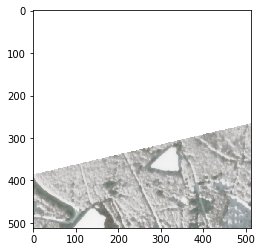

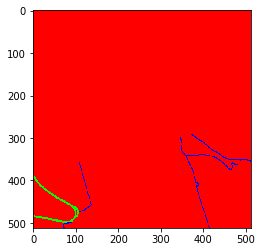

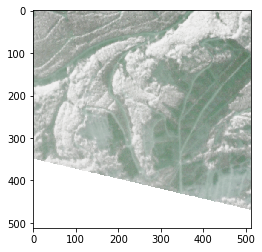

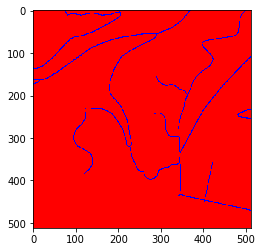

In [416]:
viewer(imList, 2, data_gen_args, 1)

In [417]:
def get_fcn_vgg16_32s(input_size, n_classes, pretrained_weights=None):
    inputs = Input(input_size)

    x = BatchNormalization()(inputs)
    
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

#     # Block 4
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

#     # Block 5
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    x = Conv2D(512, (2, 2), activation='relu', padding="same")(x)
    
    x = Conv2DTranspose(n_classes, kernel_size=(64, 64), strides=(8, 8), activation='linear', padding='same')(x)
   
    model = Model(input=inputs, output=x)
        
    model.compile(optimizer=SGD(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [418]:
model = get_fcn_vgg16_32s((512, 512, 4),3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 512, 512, 4)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 512, 512, 4)       16        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      2368      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 128, 128, 256)     295168    
__________

/home/lisa/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [ ]:
history = model.fit_generator(
    imageLoader(imList, 32, data_gen_args, 1),
    steps_per_epoch=datasize // 32,
    epochs=10
)

Epoch 1/10
